# Load data

In [11]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import json

In [12]:
name = 'regression_line'
#name = 'pca_line'
#name = 'circle'
#name = 'regression_circle'

# Read the start data
z_start = pd.read_parquet(f'../data/processed/{name}_start.parquet')
# Read the target data
z_target = pd.read_parquet(f'../data/processed/{name}_target.parquet')


# Dynamical system

In [13]:
z_size = z_start.shape[1]
hidden_size = 20

iterations = 3
map = torch.nn.Sequential(torch.nn.Linear(z_size, hidden_size),
                          torch.nn.ReLU(), 
                          torch.nn.Linear(hidden_size, hidden_size), 
                          torch.nn.ReLU(), 
                          torch.nn.Linear(hidden_size, z_size))

In [14]:
# Turn a pandas dataframe into a pytorch tensor
def df_to_tensor(df):
    return torch.tensor(df.values, dtype=torch.float32)

# Make two pytorch tensor datasets from the start and target data
z_start_tensor = df_to_tensor(z_start)
z_target_tensor = df_to_tensor(z_target)

# a dataloader which returns a batch of start and target data
class Data(torch.utils.data.Dataset):
    def __init__(self, z_start, z_target):
        self.z_start = z_start
        self.z_target = z_target
    def __len__(self):
        return len(self.z_start)
    def __getitem__(self, idx):
        return self.z_start[idx], self.z_target[idx]
    
train_data = Data(z_start_tensor, z_target_tensor)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=100, shuffle=True)

In [15]:
# Define the loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(map.parameters(), lr=0.001)

In [16]:
max_epochs = 500
# Train the model
for epoch in range(max_epochs):
    for batch_idx, (start, target) in enumerate(train_loader):
        optimizer.zero_grad()
        mapped = map(start)
        loss = criterion(mapped, target)
        loss.backward()
        optimizer.step()
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Batch {batch_idx}, Loss {loss.item()}')

Epoch 0, Batch 9, Loss 0.278055340051651


Epoch 100, Batch 9, Loss 2.3268154109246098e-05
Epoch 200, Batch 9, Loss 1.3444328942568973e-05
Epoch 300, Batch 9, Loss 2.590978738226113e-06
Epoch 400, Batch 9, Loss 1.5061173144204076e-06


# Training data

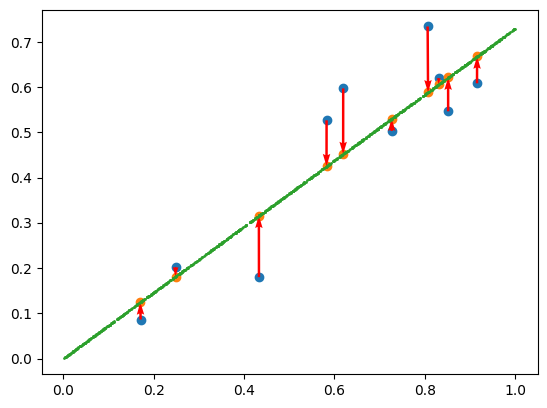

In [17]:
mapped_tensor = map(z_start_tensor).detach()

plot_points = 10

plt.figure()

plt.scatter(z_start_tensor[:plot_points,0], z_start_tensor[:plot_points,1])
plt.scatter(mapped_tensor[:plot_points,0], mapped_tensor[:plot_points,1])
dx = mapped_tensor[:plot_points,0]-z_start_tensor[:plot_points,0]
dy = mapped_tensor[:plot_points,1]-z_start_tensor[:plot_points,1]
plt.quiver(z_start_tensor[:plot_points,0], z_start_tensor[:plot_points,1], dx, dy, scale=1, scale_units='xy', angles='xy', color='r', width=0.005)

plt.scatter(z_target_tensor[:,0], z_target_tensor[:,1], s=1)
plt.gca().set_aspect('equal')
plt.show()

# Testing data

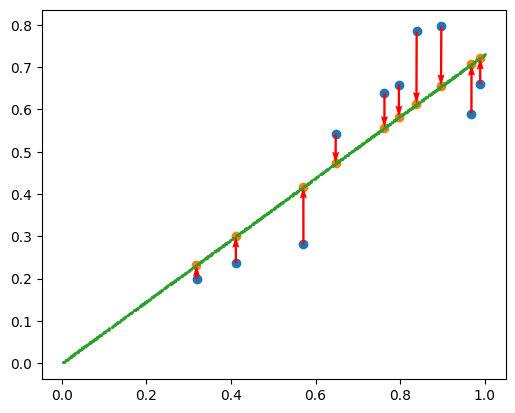

In [18]:
z_start_tensor_test = z_start_tensor+torch.rand_like(z_start_tensor)*0.2
mapped_tensor = map(z_start_tensor_test).detach()

plot_points = 10

plt.figure()

plt.scatter(z_start_tensor_test[:plot_points,0], 
            z_start_tensor_test[:plot_points,1])
plt.scatter(mapped_tensor[:plot_points,0], mapped_tensor[:plot_points,1])
dx = mapped_tensor[:plot_points,0]-z_start_tensor_test[:plot_points,0]
dy = mapped_tensor[:plot_points,1]-z_start_tensor_test[:plot_points,1]
plt.quiver(z_start_tensor_test[:plot_points,0], 
           z_start_tensor_test[:plot_points,1], 
           dx, dy, scale=1, scale_units='xy', angles='xy', color='r', width=0.005)

plt.scatter(z_target_tensor[:,0], z_target_tensor[:,1], s=1)
plt.gca().set_aspect('equal')
plt.show()